# Supervised learning

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import joblib

In [2]:
DATASET_DIR = "dataset" + os.sep
DATASET_NAME = "merge_clean_v2.csv"
ORIGINAL_DATASET_NAME = "races.csv"
ORIGINAL_CYCLIST_NAME = "cyclists.csv"
RESULTS_DIR = "results" + os.sep
MODELS_DIR = "models" + os.sep

In [3]:
dataset = pd.read_csv(DATASET_DIR + DATASET_NAME, parse_dates=["date"])
dataset = dataset.convert_dtypes()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589694 non-null  string        
 1   points             589694 non-null  Int64         
 2   length             589694 non-null  Float64       
 3   climb_total        442741 non-null  Int64         
 4   profile            475315 non-null  Int64         
 5   startlist_quality  589694 non-null  Int64         
 6   date               589694 non-null  datetime64[ns]
 7   position           589694 non-null  Int64         
 8   cyclist            589694 non-null  string        
 9   cyclist_age        589581 non-null  Int64         
 10  delta              589694 non-null  Int64         
 11  race               589694 non-null  string        
 12  year               589694 non-null  Int64         
 13  stage              589694 non-null  string  

In [4]:
old_dataset = pd.read_csv("./dataset/races.csv", parse_dates=["date"])

old_dataset.drop_duplicates(
    subset=old_dataset.columns.difference(["position"]), keep=False, inplace=True
)
old_dataset.drop_duplicates(subset=["_url", "cyclist"], keep="first", inplace=True)
old_dataset.reset_index(drop=True, inplace=True)
old_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _url                 589694 non-null  object        
 1   name                 589694 non-null  object        
 2   points               589217 non-null  float64       
 3   uci_points           251085 non-null  float64       
 4   length               589694 non-null  float64       
 5   climb_total          442741 non-null  float64       
 6   profile              441642 non-null  float64       
 7   startlist_quality    589694 non-null  int64         
 8   average_temperature  29933 non-null   float64       
 9   date                 589694 non-null  datetime64[ns]
 10  position             589694 non-null  int64         
 11  cyclist              589694 non-null  object        
 12  cyclist_age          589581 non-null  float64       
 13  is_tarmac     

In [5]:
old_cyclist_df = pd.read_csv(DATASET_DIR + ORIGINAL_CYCLIST_NAME)
old_cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [6]:
dataset.set_index(["_url", "cyclist"], inplace=True)
old_dataset.set_index(["_url", "cyclist"], inplace=True)

# resetting columns that were imputed
dataset["profile"] = old_dataset["profile"]
dataset.reset_index(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589694 non-null  string        
 1   cyclist            589694 non-null  string        
 2   points             589694 non-null  Int64         
 3   length             589694 non-null  Float64       
 4   climb_total        442741 non-null  Int64         
 5   profile            441642 non-null  float64       
 6   startlist_quality  589694 non-null  Int64         
 7   date               589694 non-null  datetime64[ns]
 8   position           589694 non-null  Int64         
 9   cyclist_age        589581 non-null  Int64         
 10  delta              589694 non-null  Int64         
 11  race               589694 non-null  string        
 12  year               589694 non-null  Int64         
 13  stage              589694 non-null  string  

In [7]:
dataset = dataset.merge(
    old_cyclist_df,
    left_on="cyclist",
    right_on="_url",
    how="inner",
    suffixes=("", "_old"),
)

dataset["height"] = dataset["height_old"]
dataset["BMI"] = dataset["weight"] / (dataset["height"] / 100) ** 2

dataset = dataset[dataset.columns.drop(list(dataset.filter(regex="_old")))]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589694 non-null  string        
 1   cyclist            589694 non-null  object        
 2   points             589694 non-null  Int64         
 3   length             589694 non-null  Float64       
 4   climb_total        442741 non-null  Int64         
 5   profile            441642 non-null  float64       
 6   startlist_quality  589694 non-null  Int64         
 7   date               589694 non-null  datetime64[ns]
 8   position           589694 non-null  Int64         
 9   cyclist_age        589581 non-null  Int64         
 10  delta              589694 non-null  Int64         
 11  race               589694 non-null  string        
 12  year               589694 non-null  Int64         
 13  stage              589694 non-null  string  

In [8]:
dataset = (
    dataset.drop(columns=["nationality", "birth_year", "delta"])
    .select_dtypes(include=["number", "bool"])
    .assign(season=dataset["season"], continent=dataset["continent"])
)
dataset["continent"] = dataset["continent"].astype("category")
dataset["season"] = dataset["season"].astype("category")
d_continent = dict(enumerate(dataset["continent"].cat.categories))
d_season = dict(enumerate(dataset["season"].cat.categories))

dataset["continent"] = dataset["continent"].cat.codes
dataset["season"] = dataset["season"].cat.codes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589694 entries, 0 to 589693
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   points             589694 non-null  Int64  
 1   length             589694 non-null  Float64
 2   climb_total        442741 non-null  Int64  
 3   profile            441642 non-null  float64
 4   startlist_quality  589694 non-null  Int64  
 5   position           589694 non-null  Int64  
 6   cyclist_age        589581 non-null  Int64  
 7   year               589694 non-null  Int64  
 8   height             479675 non-null  float64
 9   BMI                478052 non-null  float64
 10  weight             478362 non-null  float64
 11  season             589694 non-null  int8   
 12  continent          589694 non-null  int8   
dtypes: Float64(1), Int64(6), float64(4), int8(2)
memory usage: 54.6 MB


In [9]:
df_test = dataset.loc[dataset.year >= 2022].copy()
df_train = dataset.loc[dataset.year < 2022].copy()
assert len(df_test) + len(df_train) == len(dataset)

df_train.drop(columns=["year"], inplace=True)
df_test.drop(columns=["year"], inplace=True)

y_train = df_train.pop("position").apply(lambda x: 1 if x < 20 else 0)
y_test = df_test.pop("position").apply(lambda x: 1 if x < 20 else 0)

X_train = df_train
X_test = df_test

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((554288, 11), (554288,), (35406, 11), (35406,))

<Axes: >

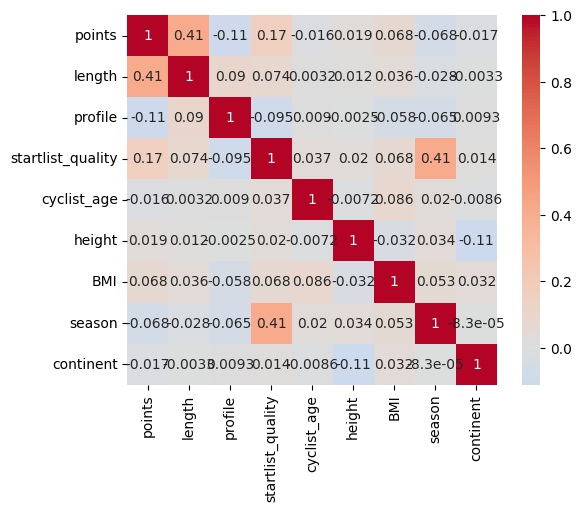

In [11]:
corr = X_train.drop(columns=["climb_total", "weight"]).corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, square=True)

In [12]:
nan_columns = X_train.columns[X_train.isna().any()].tolist()
print("Columns containing NaN values:", nan_columns)

Columns containing NaN values: ['climb_total', 'profile', 'cyclist_age', 'height', 'BMI', 'weight']


In [13]:
train_set = X_train.copy()
train_set["position"] = y_train

test_set = X_test.copy()
test_set["position"] = y_test

# reobtain the original values for season and continent
train_set["season"] = train_set["season"].map(d_season)
test_set["season"] = test_set["season"].map(d_season)

train_set["continent"] = train_set["continent"].map(d_continent)
test_set["continent"] = test_set["continent"].map(d_continent)

# Write to CSV
train_set.to_csv(DATASET_DIR + "train_set.csv", index=False)
test_set.to_csv(DATASET_DIR + "test_set.csv", index=False)

# Baseline (linear kernel SVM)

In [33]:
from sklearn.svm import LinearSVC
from sklearn.impute import KNNImputer, SimpleImputer
from libraries.supervision import (
    ColumnRemoverTransformer,
    BMICalculatorTransformer,
    get_scaler_encoder,
    get_preprocessor_svm,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.utils import shuffle
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)
from sklearn.decomposition import PCA

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554288 entries, 0 to 589693
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   points             554288 non-null  Int64  
 1   length             554288 non-null  Float64
 2   climb_total        407335 non-null  Int64  
 3   profile            406236 non-null  float64
 4   startlist_quality  554288 non-null  Int64  
 5   cyclist_age        554175 non-null  Int64  
 6   height             444688 non-null  float64
 7   BMI                443522 non-null  float64
 8   weight             443764 non-null  float64
 9   season             554288 non-null  int8   
 10  continent          554288 non-null  int8   
dtypes: Float64(1), Int64(4), float64(4), int8(2)
memory usage: 46.0 MB


In [35]:
X_train_SVC, y_train_SVC = shuffle(X_train, y_train, random_state=42)

In [43]:
FOLDS = 5
OUT_NAME = "best_svm.csv"
scores = {
    "roc_auc": make_scorer(roc_auc_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(fbeta_score, beta=1),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "accuracy": make_scorer(accuracy_score),
}

In [44]:
param_grid = {
    "classifier__C": [0.0001],
    "classifier__class_weight": [
        {0: 0.24, 1: 0.76},
    ],
}
print(param_grid)

{'classifier__C': [0.0001], 'classifier__class_weight': [{0: 0.24, 1: 0.76}]}


In [45]:
# define imputer for imputation
profile_imputer = SimpleImputer(strategy="constant", fill_value=0).set_output(
    transform="pandas"
)
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
# sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
# sampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")

general_columns = ["cyclist_age", "height", "weight"]
profile_columns = ["profile"]
preprocessor = get_preprocessor_svm(
    general_imputer, profile_imputer, general_columns, profile_columns
)


encoder = get_scaler_encoder(
    ["points", "BMI", "cyclist_age", "length", "startlist_quality"],
    ["profile", "season", "continent"],
)

clf = LinearSVC(random_state=42, max_iter=10000)
# Apply PCA to reduce dimensionality
# pca = PCA(n_components=0.97, random_state=42)  # Retain 95% of variance
# Create the pipeline
clf_pipeline = Pipeline(
    steps=[
        # ("sampling", sampler),
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("encoder", encoder),
        # ("pca", pca),
        ("classifier", clf),
    ]
)

In [46]:
grid_search = GridSearchCV(
    clf_pipeline,
    param_grid=param_grid,
    cv=FOLDS,
    refit="f0.5",
    n_jobs=-1,
    scoring=scores,
    verbose=2,
    return_train_score=True,
)

grid_search.fit(X_train_SVC, y_train_SVC)

best_model = grid_search.best_estimator_
model_path = MODELS_DIR + "best_svm.pkl"
joblib.dump(best_model, model_path)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__C=0.0001, classifier__class_weight={0: 0.24, 1: 0.76}; total time=   1.9s
[CV] END classifier__C=0.0001, classifier__class_weight={0: 0.24, 1: 0.76}; total time=   2.1s
[CV] END classifier__C=0.0001, classifier__class_weight={0: 0.24, 1: 0.76}; total time=   2.1s
[CV] END classifier__C=0.0001, classifier__class_weight={0: 0.24, 1: 0.76}; total time=   2.2s
[CV] END classifier__C=0.0001, classifier__class_weight={0: 0.24, 1: 0.76}; total time=   1.7s


['models/best_svm.pkl']

In [47]:
cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)

In [48]:
cv_results[
    [
        "params",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
        "mean_test_f0.5",
    ]
].sort_values("mean_test_f0.5", ascending=False)

,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_test_f0.5
0,"{'classifier__C': 0.0001, 'classifier__class_w...",0.78809,0.306867,0.243739,0.271679,0.56859,0.29175


## SMOTENC pipeline

In [26]:
FOLDS = 5
OUT_NAME = "svm-linear-SMOTE.csv"
scores = {
    "roc_auc": make_scorer(roc_auc_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(fbeta_score, beta=1),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "accuracy": make_scorer(accuracy_score),
}

In [ ]:
param_grid = {
    "classifier__C": [10**i for i in range(-5, 2, 1)],
    "classifier__class_weight": [
        None,
    ],
    "sampler__k_neighbors": [5],
}
print(param_grid)

In [28]:
# define imputer for imputation
profile_imputer = SimpleImputer(strategy="constant", fill_value=0).set_output(
    transform="pandas"
)
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
# sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
sampler = SMOTENC(
    random_state=42, categorical_features=["profile", "season", "continent"]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "general",
            general_imputer,
            ["cyclist_age", "height", "weight"],
        ),
        ("profile", profile_imputer, ["profile"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

scaler = ColumnTransformer(
    transformers=[
        (
            "scaler",
            StandardScaler(),
            ["points", "BMI", "cyclist_age", "length", "startlist_quality"],
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

encoder = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(), ["profile", "season", "continent"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

clf = LinearSVC(random_state=42, max_iter=10000)

# Create the pipeline
clf_pipeline = Pipeline(
    steps=[
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("scaler", scaler),
        ("sampler", sampler),
        ("encoder", encoder),
        ("classifier", clf),
    ]
)

In [ ]:
grid_search = GridSearchCV(
    clf_pipeline,
    param_grid=param_grid,
    cv=5,
    refit=False,
    n_jobs=-1,
    scoring=scores,
    verbose=2,
)

grid_search.fit(X_train_SVC, y_train_SVC)

In [ ]:
cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)

In [ ]:
cv_results[
    [
        "params",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
        "mean_test_f0.5",
    ]
].sort_values("mean_test_f0.5", ascending=False)

# RBF SVM

In [13]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from libraries.supervision import (
    ColumnRemoverTransformer,
    BMICalculatorTransformer,
    get_scaler_encoder,
    get_preprocessor_svm,
)
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)

In [14]:
X_train_rbf, y_train_rbf = shuffle(X_train, y_train, random_state=42)

In [15]:
FOLDS = 5
OUT_NAME = "svm-rbf-temp.csv"
scores = {
    "roc_auc": make_scorer(roc_auc_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(fbeta_score, beta=1),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "accuracy": make_scorer(accuracy_score),
}

In [ ]:
param_grid = {
    "classifier__C": [10**i for i in range(-5, 2, 1)],
    "classifier__class_weight": [
        "balanced",
    ],
    "classifier__kernel": ["rbf"],
    "classifier__gamma": ["scale", "auto"],
}
print(param_grid)

In [17]:
# define imputer for imputation
profile_imputer = SimpleImputer(strategy="constant", fill_value=0).set_output(
    transform="pandas"
)
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
# sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
sampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")

general_columns = ["cyclist_age", "height", "weight"]
profile_columns = ["profile"]
preprocessor = get_preprocessor_svm(
    general_imputer, profile_imputer, general_columns, profile_columns
)

encoder = get_scaler_encoder(
    ["points", "BMI", "cyclist_age", "length", "startlist_quality"],
    ["profile", "season", "continent"],
)

clf = SVC(random_state=42)

# Create the pipeline
clf_pipeline = Pipeline(
    steps=[
        # ("sampling", sampler),
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("encoder", encoder),
        ("classifier", clf),
    ]
)

In [ ]:
# grid search
grid_search = RandomizedSearchCV(
    clf_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    refit=False,
    n_jobs=-1,
    scoring=scores,
    verbose=2,
    # return_train_score=True,
)

grid_search.fit(X_train_rbf, y_train_rbf)

In [ ]:
cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)

In [ ]:
cv_results[
    [
        "params",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
        "mean_test_f0.5",
    ]
].sort_values("mean_test_f0.5", ascending=False)

# ANN

In [14]:
os.environ["KERAS_BACKEND"] = "torch"
import keras
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)
from libraries.supervision import (
    ColumnRemoverTransformer,
    BMICalculatorTransformer,
    get_scaler_encoder,
    get_preprocessor_svm,
)
from sklearn.model_selection import train_test_split

In [21]:
X_train_nn, y_train_nn = shuffle(X_train, y_train, random_state=42)
pos_class = sum(y_train_nn == 1)
neg_class = sum(y_train_nn == 0)

In [22]:
FOLDS = 5
OUT_NAME = "nn_temp-best.csv"
scores = {
    "roc_auc": make_scorer(roc_auc_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(fbeta_score, beta=1),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "accuracy": make_scorer(accuracy_score),
}

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

param_grid = {
    "classifier__epochs": [7],
    "classifier__random_state": [0],
    "classifier__batch_size": [128],
    "classifier__optimizer__learning_rate": [0.001],
    "classifier__optimizer__weight_decay": [0.001],
    # "classifier__class_weight": [
    #     {0: int(neg_class / pos_class), 1: 1},
    # ],
    # "classifier__callbacks": [[early_stopping]],
}

In [24]:
def create_model(input_shape):
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(input_shape,)),
            keras.layers.Dense(32, activation="sigmoid"),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss="binary_crossentropy")
    return model


# define imputer for imputation
profile_imputer = SimpleImputer(strategy="constant", fill_value=0).set_output(
    transform="pandas"
)
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
# sampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")

general_columns = ["cyclist_age", "height", "weight"]
profile_columns = ["profile"]
preprocessor = get_preprocessor_svm(
    general_imputer, profile_imputer, general_columns, profile_columns
)


encoder = get_scaler_encoder(
    ["points", "BMI", "cyclist_age", "length", "startlist_quality"],
    ["profile", "season", "continent"],
)

preprocess_pipeline = Pipeline(
    steps=[
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("encoder", encoder),
    ]
)

input_shape = preprocess_pipeline.fit_transform(X_train).shape[1]
keras_clf = KerasClassifier(model=create_model, verbose=0, input_shape=input_shape)


clf_pipeline = Pipeline(
    steps=[
        ("sampling", sampler),
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("encoder", encoder),
        # ("pca", pca),
        ("classifier", keras_clf),
    ]
)

In [20]:
# grid search
grid_search = RandomizedSearchCV(
    clf_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    refit=False,
    n_jobs=-1,
    scoring=scores,
    verbose=2,
    return_train_score=True,
)

grid_search.fit(X_train_nn, y_train_nn)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/saulurso/Documents/Notebooks/DM/Data-Mining/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# split the data with 0.2 validation split
X_train_nn, X_val, y_train_nn, y_val = train_test_split(
    X_train_nn, y_train_nn, test_size=0.2, random_state=42
)

# Create preprocessing pipeline
preprocess_pipeline = Pipeline(
    steps=[
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("encoder", encoder),
    ]
)

# resample training
X_train_nn, y_train_nn = sampler.fit_resample(X_train_nn, y_train_nn)


# Fit and transform training data
X_train_preprocessed = preprocess_pipeline.fit_transform(X_train_nn)
X_val_preprocessed = preprocess_pipeline[1:].transform(X_val)

# Create and compile the model
model = create_model(input_shape=X_train_preprocessed.shape[1])

# Train the model
history = model.fit(
    X_train_preprocessed,
    y_train_nn,
    epochs=100,
    batch_size=128,
    validation_data=(X_val_preprocessed, y_val),
    callbacks=[early_stopping],
    verbose=1,
)

# Save both the preprocessing pipeline and the model
joblib.dump(preprocess_pipeline, MODELS_DIR + "nn_preprocessor.pkl")
model.save(MODELS_DIR + "nn_model.keras")

Epoch 1/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.6719 - val_loss: 20.4609
Epoch 2/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.6570 - val_loss: 20.4394
Epoch 3/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.6499 - val_loss: 20.4384
Epoch 4/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.6467 - val_loss: 20.4358
Epoch 5/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.6453 - val_loss: 20.4381
Epoch 6/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.6443 - val_loss: 20.4510
Epoch 7/100
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.6432 - val_loss: 20.4401


In [26]:
# split the data with 0.2 validation split
X_train_nn, X_val, y_train_nn, y_val = train_test_split(
    X_train_nn, y_train_nn, test_size=0.2, random_state=42
)

# Initialize a new keras classifier with validation data
keras_clf = KerasClassifier(
    model=create_model,
    input_shape=input_shape,
    epochs=7,
    batch_size=128,
    random_state=0,
    optimizer__learning_rate=0.001,
    optimizer__weight_decay=0.001,
    callbacks=[early_stopping],
    verbose=0,
)

# Create a new pipeline with the updated classifier
clf_pipeline = Pipeline(
    steps=[
        ("sampling", sampler),
        ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        ("encoder", encoder),
        ("classifier", keras_clf),
    ]
)

# Apply all preprocessing steps except sampling and classifier to X_val
preprocessed_X_val = (
    Pipeline(
        [
            ("imputation", preprocessor),
            ("bmi", BMICalculatorTransformer()),
            ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
            ("encoder", encoder),
        ]
    )
    .fit(X_train_nn)
    .transform(X_val)
)

# fit the pipeline
history = clf_pipeline.fit(
    X_train_nn,
    y_train_nn,
    classifier__validation_data=(preprocessed_X_val, y_val),
)

# save the model
joblib.dump(clf_pipeline, MODELS_DIR + "best_nn.pkl")

['models/best_nn.pkl']

In [33]:
cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)

In [34]:
cv_results[
    [
        "params",
        "param_classifier__optimizer__learning_rate",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
        "mean_test_f0.5",
    ]
].sort_values("mean_test_f0.5", ascending=False)

,params,param_classifier__optimizer__learning_rate,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_test_f0.5
0,"{'classifier__random_state': 0, 'classifier__o...",0.001,0.642365,0.248214,0.592964,0.349725,0.622445,0.280802


# Random Forest

In [65]:
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from libraries.supervision import (
    ColumnRemoverTransformer,
    BMICalculatorTransformer,
    get_encoder,
    get_general_preprocessor,
)
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)
import joblib
from sklearn.metrics import classification_report

In [66]:
X_train_RF, y_train_RF = shuffle(X_train, y_train, random_state=42)

In [67]:
X_train_RF["cyclist_age"] = X_train_RF.cyclist_age.astype("float64").replace(
    {pd.NA: np.nan}
)

In [68]:
FOLDS = 5
OUT_NAME = "rf-temp-best.csv"
scores = {
    "roc_auc": make_scorer(roc_auc_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(fbeta_score, beta=1),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "accuracy": make_scorer(accuracy_score),
}

In [69]:
param_grid = {
    "classifier__n_estimators": [300],
    "classifier__max_features": [0.75],
    "classifier__max_depth": [25],
    "classifier__class_weight": [
        {0: 0.46, 1: 0.54},
    ],
}

In [70]:
# define imputer for imputation
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
# sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
# sampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")

preprocessor = get_general_preprocessor(
    ["cyclist_age", "height", "weight"], general_imputer
)

onehot_columns = ["season", "continent", "profile"]
encoder = get_encoder(onehot_columns)

clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Create the pipeline
clf_pipeline_rf = Pipeline(
    steps=[
        # ("sampling", sampler),
        # ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        (
            "remove",
            ColumnRemoverTransformer(["weight", "climb_total", "height"]),
        ),
        ("encoder", encoder),
        ("classifier", clf_rf),
    ]
)

In [71]:
grid_search_rf = RandomizedSearchCV(
    clf_pipeline_rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    refit="f0.5",
    scoring=scores,
    verbose=2,
    return_train_score=True,
)
grid_search_rf.fit(X_train_RF, y_train_RF)

/Users/saulurso/Documents/Notebooks/DM/Data-Mining/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__class_weight={0: 0.46, 1: 0.54}, classifier__max_depth=25, classifier__max_features=0.75, classifier__n_estimators=300; total time= 1.5min
[CV] END classifier__class_weight={0: 0.46, 1: 0.54}, classifier__max_depth=25, classifier__max_features=0.75, classifier__n_estimators=300; total time= 1.3min
[CV] END classifier__class_weight={0: 0.46, 1: 0.54}, classifier__max_depth=25, classifier__max_features=0.75, classifier__n_estimators=300; total time= 1.3min
[CV] END classifier__class_weight={0: 0.46, 1: 0.54}, classifier__max_depth=25, classifier__max_features=0.75, classifier__n_estimators=300; total time= 1.4min
[CV] END classifier__class_weight={0: 0.46, 1: 0.54}, classifier__max_depth=25, classifier__max_features=0.75, classifier__n_estimators=300; total time= 1.4min


/Users/saulurso/Documents/Notebooks/DM/Data-Mining/venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('bmi',
                                              BMICalculatorTransformer()),
                                             ('remove',
                                              ColumnRemoverTransformer(columns=['weight',
                                                                                'climb_total',
                                                                                'height'])),
                                             ('encoder',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['season',
                                                                                'continent',
                                                                                'profile'])],
                                                                verbose_feature_names_out=False)),
                                             (...
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f0.5': make_scorer(fbeta_score, response_method='predict', beta=0.5),
                            'f1': make_scorer(fbeta_score, response_method='predict', beta=1),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')},
                   verbose=2)

In [72]:
cv_results = pd.DataFrame.from_dict(grid_search_rf.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)
best_model = grid_search_rf.best_estimator_
joblib.dump(best_model, MODELS_DIR + "best_rf.pkl")

['models/best_rf.pkl']

In [22]:
res = cv_results[
    [
        "params",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
        "mean_test_f0.5",
        "mean_train_f0.5",
    ]
].sort_values("mean_test_f0.5", ascending=False)

for i, row in res.iterrows():
    print(row["params"])
    print(row["mean_test_f0.5"])
    print()

# {'classifier__n_estimators': 300, 'classifier__max_features': 0.75, 'classifier__max_depth': 25, 'classifier__class_weight': same as svc} 0.512991

{'classifier__n_estimators': 300, 'classifier__max_features': 0.75, 'classifier__max_depth': 25, 'classifier__class_weight': {0: 0.46, 1: 0.54}}
0.5273439024470432



# XGBoost

In [14]:
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from libraries.supervision import (
    ColumnRemoverTransformer,
    BMICalculatorTransformer,
    get_encoder,
    get_general_preprocessor,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)
from math import sqrt

In [15]:
X_train_XGB, y_train_XGB = shuffle(X_train, y_train, random_state=42)
pos_class = sum(y_train_XGB == 1)
neg_class = sum(y_train_XGB == 0)
X_train_XGB["profile"] = X_train_XGB.profile.astype("category")
X_train_XGB["season"] = X_train_XGB.season.astype("category")
X_train_XGB["continent"] = X_train_XGB.continent.astype("category")
X_train_XGB["cyclist_age"] = X_train_XGB.cyclist_age.astype("float64").replace(
    {pd.NA: np.nan}
)

In [16]:
FOLDS = 5
OUT_NAME = "XGB-temp-best.csv"
scores = {
    "roc_auc": make_scorer(roc_auc_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(fbeta_score, beta=1),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "accuracy": make_scorer(accuracy_score),
}

In [17]:
param_grid = {
    "classifier__n_estimators": [2500],
    "classifier__max_depth": [10],
    "classifier__learning_rate": [0.3],
    "classifier__subsample": [1],
    "classifier__scale_pos_weight": [
        (neg_class / pos_class) / 32,
    ],
    "classifier__min_child_weight": [
        1,
    ],
    "classifier__gamma": [0],
}

In [18]:
# define imputer for imputation
general_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

# define sampler for sampling
sampler = RandomOverSampler(random_state=42, sampling_strategy="minority")
# sampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
impute_columns = ["cyclist_age", "height", "weight"]
preprocessor = get_general_preprocessor(impute_columns, general_imputer)

onehot_columns = ["profile", "season", "continent"]
encoder = get_encoder(onehot_columns)

clf_xgb = XGBClassifier(random_state=42, enable_categorical=True)

# Create the pipeline
clf_pipeline_xgb = Pipeline(
    steps=[
        # ("sampling", sampler),
        # ("imputation", preprocessor),
        ("bmi", BMICalculatorTransformer()),
        ("remove", ColumnRemoverTransformer(["weight", "climb_total", "height"])),
        # ("encoder", encoder),
        ("classifier", clf_xgb),
    ]
)

In [20]:
# grid search
grid_search_xgb = RandomizedSearchCV(
    clf_pipeline_xgb,
    param_distributions=param_grid,
    n_iter=8,
    cv=5,
    refit="f0.5",
    scoring=scores,
    verbose=2,
    n_jobs=1,
    return_train_score=True,
)

grid_search_xgb.fit(X_train_XGB, y_train_XGB)

/Users/saulurso/Documents/Notebooks/DM/Data-Mining/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=8. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__min_child_weight=1, classifier__n_estimators=2500, classifier__scale_pos_weight=0.1614702127304487, classifier__subsample=1; total time=  40.8s
[CV] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__min_child_weight=1, classifier__n_estimators=2500, classifier__scale_pos_weight=0.1614702127304487, classifier__subsample=1; total time=  41.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__min_child_weight=1, classifier__n_estimators=2500, classifier__scale_pos_weight=0.1614702127304487, classifier__subsample=1; total time=  37.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__min_child_weight=1, classifier__n_estimators=2500, classifier__scale_pos_weight=0.1614702127304487, classifier__s

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('bmi',
                                              BMICalculatorTransformer()),
                                             ('remove',
                                              ColumnRemoverTransformer(columns=['weight',
                                                                                'climb_total',
                                                                                'height'])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_c...
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f0.5': make_scorer(fbeta_score, response_method='predict', beta=0.5),
                            'f1': make_scorer(fbeta_score, response_method='predict', beta=1),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')},
                   verbose=2)

In [21]:
cv_results = pd.DataFrame.from_dict(grid_search_xgb.cv_results_)
cv_results.to_csv(RESULTS_DIR + OUT_NAME, index=False)
best_model = grid_search_xgb.best_estimator_
joblib.dump(best_model, MODELS_DIR + "best_xgb.pkl")

['models/best_xgb.pkl']

In [22]:
res = cv_results[
    [
        "params",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_f1",
        "mean_test_roc_auc",
        "mean_test_f0.5",
        # "mean_train_f0.5",
    ]
].sort_values("mean_test_f0.5", ascending=False)

for i, row in res.iterrows():
    print(row["params"])
    print(row["mean_test_f0.5"])
    print()

# 0.413

{'classifier__subsample': 1, 'classifier__scale_pos_weight': 0.1614702127304487, 'classifier__n_estimators': 2500, 'classifier__min_child_weight': 1, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0}
0.5268604270426449



# Test scores

In [27]:
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [28]:
MODELS_DIR = "models" + os.sep
SMV_MODEL_NAME = "best_svm.pkl"
RF_MODEL_NAME = "best_rf.pkl"
XGB_MODEL_NAME = "best_xgb.pkl"
NN_MODEL_NAME = "nn_model.keras"
NN_PREPROCESSOR_NAME = "nn_preprocessor.pkl"

## SVM

In [34]:
svm_model = joblib.load(MODELS_DIR + SMV_MODEL_NAME)
y_pred = svm_model.predict(X_test)
print("SVM")
print(classification_report(y_test, y_pred))

SVM
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     30466
           1       0.16      0.00      0.00      4940

    accuracy                           0.86     35406
   macro avg       0.51      0.50      0.46     35406
weighted avg       0.76      0.86      0.80     35406



<Axes: >

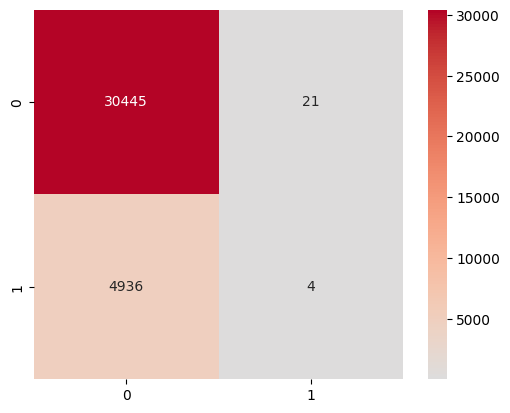

In [35]:
conf_matr = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matr, annot=True, cmap="coolwarm", center=0, square=True, fmt="d")

## ANN

In [48]:
preprocessor = joblib.load(MODELS_DIR + NN_PREPROCESSOR_NAME)
model = keras.models.load_model(MODELS_DIR + NN_MODEL_NAME)
X_test_preprocessed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_preprocessed)
y_pred = (y_pred > 0.5).astype(int)
print("NN")
print(classification_report(y_test, y_pred))

1107/1107 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step
NN
              precision    recall  f1-score   support

           0       0.89      0.74      0.81     30466
           1       0.22      0.44      0.29      4940

    accuracy                           0.70     35406
   macro avg       0.55      0.59      0.55     35406
weighted avg       0.80      0.70      0.74     35406



<Axes: >

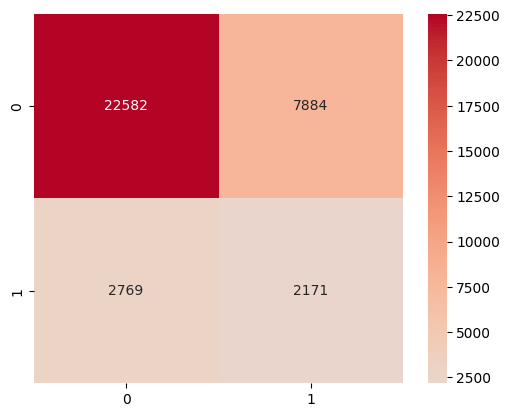

In [49]:
conf_matr = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matr, annot=True, cmap="coolwarm", center=0, square=True, fmt="d")

## RF

In [36]:
rf_model = joblib.load(MODELS_DIR + RF_MODEL_NAME)
y_pred = rf_model.predict(X_test)
print("RF")
print(classification_report(y_test, y_pred))

RF
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     30466
           1       0.36      0.07      0.12      4940

    accuracy                           0.85     35406
   macro avg       0.61      0.53      0.52     35406
weighted avg       0.80      0.85      0.81     35406



<Axes: >

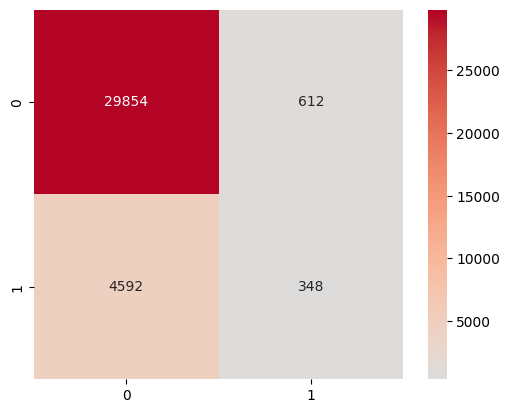

In [37]:
conf_matr = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matr, annot=True, cmap="coolwarm", center=0, square=True, fmt="d")

## XGB

In [38]:
xgb_model = joblib.load(MODELS_DIR + XGB_MODEL_NAME)
y_pred = xgb_model.predict(X_test)
print("XGB")
print(classification_report(y_test, y_pred))

XGB
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     30466
           1       0.19      0.19      0.19      4940

    accuracy                           0.77     35406
   macro avg       0.53      0.53      0.53     35406
weighted avg       0.78      0.77      0.77     35406



<Axes: >

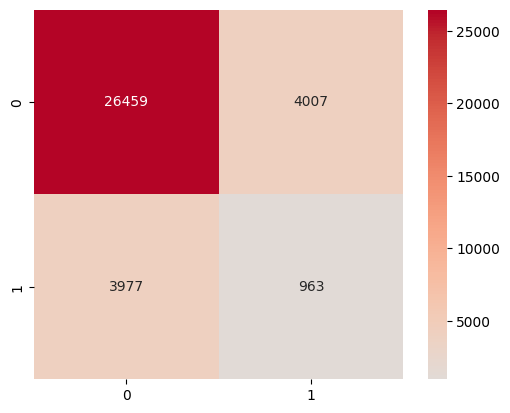

In [39]:
conf_matr = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matr, annot=True, cmap="coolwarm", center=0, square=True, fmt="d")